### Import libraries

In [344]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, shuffle
from tensorflow.keras import mixed_precision
import warnings
import logging

# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

print(tf.config.list_physical_devices())

import shutil
from IPython.display import FileLink


2.6.4
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Set seed for reproducibility

In [345]:
# Random seed for reproducibility
seed = 102

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Hyper parameters for augmentation, splines interpolation and scaling

In [346]:
scaling = True # applies standard scaling to the data
apply_oversampling = False 
interpolation_multiplier = 3 # resolution multiplier
augment_std = 0.04# introduces noise to the oversampled data
use_cross_valid = False

 ## Load the training dataset

In [347]:
path = "/kaggle/input/training/"
# Load the .npy file
X = np.load(path + "x_train.npy")
y = np.load(path + "y_train.npy")

# Convert to float32 for less precision and better performance
X = X.astype(np.float32)
y = y.astype(np.int32)

# shuffle X, y
X, y = shuffle(X, y, random_state=seed)

print(X.shape, X.dtype, sep=", ")   
print(y.shape, y.dtype, sep=", ") 

(2429, 36, 6), float32
(2429,), int32


Training - Validation Split

In [348]:
if not use_cross_valid:
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,shuffle=True, random_state=seed, stratify=y)
    print("training set : ", X_train.shape)
    print("test set: ", X_test.shape)

training set :  (2064, 36, 6)
test set:  (365, 36, 6)


Plotting the classes distributions

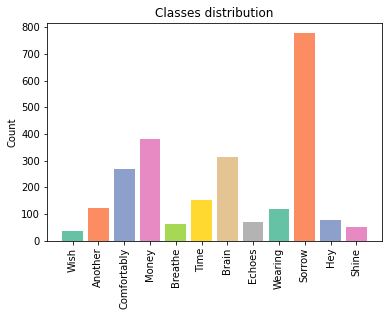

In [349]:
# Map classes STRINGS to integers
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11,  
}

#vertical bar plot of the classes distribution in y
plt.title('Classes distribution')
plt.bar(label_mapping.keys(), np.bincount(y), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()


Class weights computation

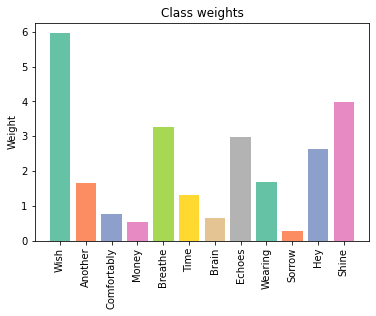

In [350]:
# Compute the class weights in order to balance loss during training
labels = np.unique(np.fromiter([t for t in y], np.int32))
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y)))

# plot class weights with respect to the labels
plt.title('Class weights')
plt.bar(label_mapping.keys(), class_weights.values(), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Weight')
plt.show()


## Data preprocessing with cubic interpolation between data points for increasing resolution

Before the cubic spline interpolation 

In [351]:
def spline_augment_print(X_train,y_train,interpolation_multiplier = 3,augment_std = 0.02):
    # plot the sequence of points in a randomly drawn sample from X
    sample = random.randint(0, X_train.shape[0])

    # create a figure with 6 subplots, one plot per each feature
    fig, axs = plt.subplots(6, 1, figsize=(9, 13))
    fig.suptitle('Sample ' + str(sample))
    for i in range(6):
        axs[i].set_title('Feature ' + str(i))
        # add a dot at each point in the sequence
        axs[i].plot(X_train[sample, :, i], 'o-', color='blue', markersize=4)

    plt.show()
    
    from scipy import interpolate

    # triple the number of points in the sequence to increase the resolution by a factor of 3
    x_lin = np.linspace(0, 35, 36 * interpolation_multiplier)

    # new augmented dataset
    X_spline = np.zeros((X_train.shape[0], x_lin.size, 6))
    print(X_spline.shape)

    for i in np.arange(X_train[:, 0, 0].size): # for each sample
        for j in np.arange(6): # for each feature
            # add a cubic spline interpolation between the data points of X[sample, :, 0]
            interpolation = interpolate.interp1d(np.arange(0, 36), X_train[i, :, j], kind='cubic', fill_value="extrapolate")
            X_spline[i, :, j] = interpolation(x_lin)
    # create a figure with 6 subplots, one plot per each feature
    fig, axs = plt.subplots(6, 1, figsize=(9, 14))
    fig.suptitle('Sample ' + str(sample))
    for i in range(6):
        axs[i].set_title('Feature ' + str(i))
        # plots the given sequence of points without interpolation
        axs[i].plot(np.arange(0, 36), X_train[sample, :, i], 'o-', color='blue', markersize=4)

        # plots the new set of points with cubic spline interpolation
        axs[i].plot(x_lin, X_spline[sample, :, i], "o-", color='red', markersize = 3, alpha = 0.7)
    plt.show()
    # create a new augmented dataset with the new samples that is as big as the original training dataset
    X_augmented = np.empty((0, X_train.shape[1], X_train.shape[2]), dtype=np.float32)
    y_augmented = np.empty((0,), dtype=np.int32)

    print("interpolation_multiplier = ", interpolation_multiplier)

    # for each sample in the training dataset
    for i in range(y_train.shape[0]):

        # copy the original sample in the augmented dataset every 3 points from X_spline[i, k, :]
        for j in range(interpolation_multiplier):
            X_augmented = np.append(X_augmented, np.expand_dims(X_spline[i, j::interpolation_multiplier, :], axis=0), axis=0)
            y_augmented = np.append(y_augmented, np.expand_dims(y_train[i], axis=0), axis=0)

            # for each sample, add a random gaussian noise to each feature

            for k in range(X_augmented.shape[2]):
                mins = np.min(X_augmented[-1, :, k], axis=0)
                maxs = np.max(X_augmented[-1, :, k], axis=0)

                values = np.random.normal(0, augment_std * (maxs - mins), X_augmented.shape[1])
                X_augmented[-1, :, k] = np.add(X_augmented[-1, :, k], values)

    print("new augmented dataset size ", X_augmented.shape, y_augmented.shape, sep=", ")

    # shuffle the data
    X_augmented, y_augmented = shuffle(X_augmented, y_augmented, random_state=seed)
    
    return X_augmented, y_augmented

In [352]:
#redefining the function not to print (to be used in crossvalidation)
def spline_augment_no_print(X_train,y_train,interpolation_multiplier = 3,augment_std = 0.02):

    from scipy import interpolate

    # triple the number of points in the sequence to increase the resolution by a factor of 3
    x_lin = np.linspace(0, 35, 36 * interpolation_multiplier)

    # new augmented dataset
    X_spline = np.zeros((X_train.shape[0], x_lin.size, 6))


    for i in np.arange(X_train[:, 0, 0].size): # for each sample
        for j in np.arange(6): # for each feature
            # add a cubic spline interpolation between the data points of X[sample, :, 0]
            interpolation = interpolate.interp1d(np.arange(0, 36), X_train[i, :, j], kind='cubic', fill_value="extrapolate")
            X_spline[i, :, j] = interpolation(x_lin)
    
    # create a new augmented dataset with the new samples that is as big as the original training dataset
    X_augmented = np.empty((0, X_train.shape[1], X_train.shape[2]), dtype=np.float32)
    y_augmented = np.empty((0,), dtype=np.int32)

    # for each sample in the training dataset
    for i in range(y_train.shape[0]):

        # copy the original sample in the augmented dataset every 3 points from X_spline[i, k, :]
        for j in range(interpolation_multiplier):
            X_augmented = np.append(X_augmented, np.expand_dims(X_spline[i, j::interpolation_multiplier, :], axis=0), axis=0)
            y_augmented = np.append(y_augmented, np.expand_dims(y_train[i], axis=0), axis=0)

            # for each sample, add a random gaussian noise to each feature

            for k in range(X_augmented.shape[2]):
                mins = np.min(X_augmented[-1, :, k], axis=0)
                maxs = np.max(X_augmented[-1, :, k], axis=0)

                values = np.random.normal(0, augment_std * (maxs - mins), X_augmented.shape[1])
                X_augmented[-1, :, k] = np.add(X_augmented[-1, :, k], values)

    # shuffle the data
    X_augmented, y_augmented = shuffle(X_augmented, y_augmented, random_state=seed)
    
    return X_augmented, y_augmented

## Application of Standard Scaler to the dataset

In [353]:
if not use_cross_valid:
    #X_train = np.delete(X_train, 3, axis=2)
    #X_test = np.delete(X_test, 3, axis=2)
    
    features_num = X_train.shape[2]
    print("features: ", features_num)

    #(optional) apply spline augmentation
    #X_train,y_train = spline_augment_print(X_train,y_train,interpolation_multiplier = 3,augment_std = 0.02)
    # if the standard scaling is requested, computes it on the training set and prints its values
    if (scaling):
        scaler_robust = RobustScaler()
        scaler_std = StandardScaler()
        scaler_0 = MinMaxScaler(feature_range=(0,1))
        #scaler_1 = MinMaxScaler(feature_range=(-1,1))

        num_instances, num_time_steps, num_features = X_train.shape
        X_train = np.reshape(X_train, newshape=(-1, num_features))
        X_train = scaler_robust.fit_transform(X_train)
        X_train = scaler_0.fit_transform(X_train)
        X_train = scaler_std.fit_transform(X_train)

        X_train = np.reshape(X_train, newshape=(num_instances, num_time_steps, num_features))

        num_instances, num_time_steps, num_features = X_test.shape
        X_test = np.reshape(X_test, newshape=(-1, num_features))
        X_test = scaler_robust.transform(X_test)
        X_test = scaler_0.transform(X_test)
        X_test = scaler_std.transform(X_test)

        X_test = np.reshape(X_test, newshape=(num_instances, num_time_steps, num_features))
        #print("std_scaler: "+str(scaler_std.__dict__))
        #print("min_max_scaler_1: "+str(scaler_1.__dict__))
        #print("min_max_scaler_0: "+str(scaler_0.__dict__))


features:  6


Categorical labels for the training and test data

In [354]:
if not use_cross_valid:   
    # Convert the sparse labels to categorical values
    y_train = tfk.utils.to_categorical(y_train)
    y_test = tfk.utils.to_categorical(y_test)
    print(X_train.shape, y_train.shape, sep=", ")
    print(X_test.shape, y_test.shape, sep=", ")

(2064, 36, 6), (2064, 12)
(365, 36, 6), (365, 12)


## Build the models

Hyperparameters

In [355]:
if not use_cross_valid:  
    input_shape = X_train.shape[1:]
    print("input shape: ", input_shape)
    classes = y_train.shape[-1]
batch_size = 512
epochs = 1000


input shape:  (36, 6)


Plot history of the training and the learning rate schedule

In [356]:
def plot_history(history):
	best_epoch = np.argmax(history['val_accuracy'])
	plt.figure(figsize=(17,4))
	plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
	plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
	plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
	plt.title('Categorical Crossentropy')
	plt.legend()
	plt.grid(alpha=.3)
	plt.show()

	plt.figure(figsize=(17,4))
	plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
	plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
	plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
	plt.title('Accuracy')
	plt.legend()
	plt.grid(alpha=.3)
	plt.show()

	plt.figure(figsize=(17,4))
	plt.title('Learning Rate Schedule')
	plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
	plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
	plt.legend()
	plt.grid(alpha=.3)
	plt.show()

Plot confusion matrix, F1 scores and displays model accuracy

In [357]:
def plot_statistics(predictions):	
	# Compute the confusion matrix
	cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

	# Compute the classification metrics
	accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
	precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
	recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
	f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
	print('Accuracy:',accuracy.round(4))
	print('Precision:',precision.round(4))
	print('Recall:',recall.round(4))
	print('F1:',f1.round(4))

	# Plot the confusion matrix
	plt.figure(figsize=(7, 6))
	plt.title('Confusion matrix')
	sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()), annot=True, fmt="d")
	plt.xlabel('True labels')
	plt.ylabel('Predicted labels')
	plt.show()

	# horizontal bar plot of the f1 scores for each class
	plt.figure(figsize=(6,4))
	plt.grid(alpha=.3)
	plt.barh(y=list(label_mapping.keys()), width=f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average=None))
	plt.title('F1 scores')
	plt.show()

In [358]:
from keras import backend as K

class AttentionLayer(tfkl.Layer):
    def _init_(self, **kwargs):
        super(AttentionLayer, self)._init_(**kwargs)

    def build(self, input_shape):
        # create a trainable weight variable for this layer which is used to compute a score for each time step in the input sequence
        self.W = self.add_weight(name='attention_weight', 
                                 shape=(input_shape[-1], 1),
                                 initializer='uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs, mask=None):
        # inputs: (batch_size, time_steps, input_dim)
        # mask: (batch_size, time_steps)

        # apply a dot product between the input and the trainable weight to
        # get a score for each time step
        score = K.dot(inputs, self.W)
        score = K.squeeze(score, axis=-1)
        # apply a softmax activation to the score to compute the attention
        # weights for each time step
        attention_weights = K.softmax(score)
        # multiply the attention weights by the input to compute the
        # weighted sum of the input
        weighted_sum = K.sum(K.expand_dims(attention_weights, axis=-1) * inputs, axis=1)
        # return the attention-weighted sum of the input
        return weighted_sum

    def compute_output_shape(self, input_shape):
        # the output shape is the same as the input shape, except the input
        # dimension is reduced by one
        return (input_shape[0], input_shape[-1])

#### Only convolutional and dense layers

In [359]:


def build_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    
    #head1
    y = tfkl.Conv1D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv1y')(input_layer)

    #y = tfkl.Dropout(0.2, seed=seed)(y)

    y = tfkl.Conv1D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv2y')(y)
    
    #y = tfkl.Dropout(0.2, seed=seed)(y)
    
    y = tfkl.Conv1D(
        filters = 128,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv3y')(y)

    #y = tfkl.Dropout(0.2, seed=seed)(y)
    

    #head4-LSTM
    
    r = tfkl.Bidirectional(tfkl.GRU(60, return_sequences=True, name='lstm1'))(y)
    r = tfkl.Dropout(0.5, seed=seed)(r)
    r = tfkl.Bidirectional(tfkl.GRU(60, return_sequences=True, name='lstm2'))(r)
    r = tfkl.Dropout(0.5, seed=seed)(r)

    #x = tfkl.Bidirectional(tfkl.GRU(16, return_sequences=True, name='lstm3'))(y)
    #x = tfkl.Dropout(0.4, seed=seed)(x)
    #x = tfkl.Bidirectional(tfkl.GRU(16, return_sequences=False, name='lstm2'))(x)
    #x = tfkl.Dropout(0.4, seed=seed)(x)

    #x = tfkl.GlobalAveragePooling1D()(r)
    #x = tfkl.Dropout(0.3, seed=seed)(x)
    x = AttentionLayer()(r)

    #x = tfkl.Dropout(0.3, seed=seed)(x)
    output_layer = tfkl.Dense(classes, activation='softmax',kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model1')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(3e-3), metrics='accuracy')

    # Return the model
    return model

In [360]:
if not use_cross_valid:  
    model = build_classifier(input_shape,classes)
    model.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
conv1y (Conv1D)              (None, 36, 256)           4864      
_________________________________________________________________
conv2y (Conv1D)              (None, 36, 256)           196864    
_________________________________________________________________
conv3y (Conv1D)              (None, 36, 128)           98432     
_________________________________________________________________
bidirectional_62 (Bidirectio (None, 36, 120)           68400     
_________________________________________________________________
dropout_68 (Dropout)         (None, 36, 120)           0         
_________________________________________________________________
bidirectional_63 (Bidirectio (None, 36, 120)           65520

In [361]:
if not use_cross_valid:
    
    # Train the model
    history = model.fit(
        x = X_train,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_data = (X_test, y_test),
        #class_weight = class_weights,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=150, restore_best_weights=True),
            #tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=7, factor=tf.math.exp(-0.1), min_lr=5e-5)
            tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.4, min_lr=5e-5)
        ]
    ).history

Epoch 1/1000
5/5 [==============================] - 7s 294ms/step - loss: 2.2049 - accuracy: 0.2752 - val_loss: 2.0605 - val_accuracy: 0.1890
Epoch 2/1000
5/5 [==============================] - 0s 36ms/step - loss: 1.9162 - accuracy: 0.3358 - val_loss: 1.8262 - val_accuracy: 0.3973
Epoch 3/1000
5/5 [==============================] - 0s 39ms/step - loss: 1.7499 - accuracy: 0.4191 - val_loss: 1.7607 - val_accuracy: 0.4247
Epoch 4/1000
5/5 [==============================] - 0s 36ms/step - loss: 1.6466 - accuracy: 0.4419 - val_loss: 1.7275 - val_accuracy: 0.4192
Epoch 5/1000
5/5 [==============================] - 0s 36ms/step - loss: 1.6374 - accuracy: 0.4385 - val_loss: 1.6152 - val_accuracy: 0.4329
Epoch 6/1000
5/5 [==============================] - 0s 36ms/step - loss: 1.5061 - accuracy: 0.4782 - val_loss: 1.5342 - val_accuracy: 0.4740
Epoch 7/1000
5/5 [==============================] - 0s 39ms/step - loss: 1.4260 - accuracy: 0.5015 - val_loss: 1.4756 - val_accuracy: 0.4959
Epoch 8/1000

Convolutional model evaluation

In [ ]:
if not use_cross_valid:
    plot_history(history)

    # Predict the test set with the LSTM
    predictions = model.predict(X_test)

    plot_statistics(predictions)

Save model with the validation accuracy in the name

In [ ]:
if not use_cross_valid:
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    if (accuracy > 0.765):
        model_name = "TUNED_GRU_" + str(accuracy.round(6))
        model.save(model_name)

        
        FileLink(r"" + model_name + ".zip")
        import joblib
        scaler_std_filename =model_name+ "/scaler_std.save"
        joblib.dump(scaler_std, scaler_std_filename) 
        scaler_0_filename =model_name+ "/scaler_0.save"
        joblib.dump(scaler_0, scaler_0_filename) 
        #scaler_robust_filename =model_name+ "/scaler_robust.save"
        #joblib.dump(scaler_robust, scaler_robust_filename) 

        shutil.make_archive(model_name, 'zip', model_name)


Cross Validation

In [ ]:
def scale_feature_wise(X_train, X_test):  #apply rescaling to each feature
    scaler_robust = RobustScaler()
    scaler_std = StandardScaler()
    scaler_0 = MinMaxScaler(feature_range=(0,1))
    scaler_1 = MinMaxScaler(feature_range=(-1,1))

    num_instances, num_time_steps, num_features = X_train.shape
    X_train = np.reshape(X_train, newshape=(-1, num_features))
    #X_train = scaler_robust.fit_transform(X_train)
    X_train = scaler_0.fit_transform(X_train)
    X_train = scaler_std.fit_transform(X_train)

    X_train = np.reshape(X_train, newshape=(num_instances, num_time_steps, num_features))

        
    
    if X_test is not None:
        num_instances, num_time_steps, num_features = X_test.shape
        X_test = np.reshape(X_test, newshape=(-1, num_features))
        #X_test = scaler_robust.transform(X_test)
        X_test = scaler_0.transform(X_test)
        X_test = scaler_std.transform(X_test)

        X_test = np.reshape(X_test, newshape=(num_instances, num_time_steps, num_features))
        return X_train, X_test
    
    return X_train
    

In [ ]:
def scale_feature_wise_pca(X_train, X_test, n_components = 6):  #apply rescaling to each feature and use pca to reduce the number of features
    from sklearn.decomposition import PCA
    
    scaler_robust = RobustScaler()
    scaler_std = StandardScaler()
    scaler_0 = MinMaxScaler(feature_range=(0,1))
    scaler_1 = MinMaxScaler(feature_range=(-1,1))

    num_instances, num_time_steps, num_features = X_train.shape
    X_train = np.reshape(X_train, newshape=(-1, num_features))
    #X_train = scaler_robust.fit_transform(X_train)
    X_train = scaler_0.fit_transform(X_train)
    X_train = scaler_std.fit_transform(X_train)
    
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    num_features = pca.n_components_
    print("("+str(num_features)+" PCA components)")
    
    X_train = np.reshape(X_train, newshape=(num_instances, num_time_steps, num_features))

        
    
    if X_test is not None:
        num_instances, num_time_steps, num_features = X_test.shape
        X_test = np.reshape(X_test, newshape=(-1, num_features))
        #X_test = scaler_robust.transform(X_test)
        X_test = scaler_0.transform(X_test)
        X_test = scaler_std.transform(X_test)
        
        X_test = pca.transform(X_test)
        num_features = pca.n_components_
        
        X_test = np.reshape(X_test, newshape=(num_instances, num_time_steps, num_features))
        return X_train, X_test
    
    return X_train
    

In [ ]:
def scale_ts_feature_wise(X_train, X_test):  #apply rescaling to each (timestamp,feature) pair
    scaler_robust = RobustScaler()
    scaler_std = StandardScaler()
    scaler_0 = MinMaxScaler(feature_range=(0,1))
    scaler_1 = MinMaxScaler(feature_range=(-1,1))

    num_instances, num_time_steps, num_features = X_train.shape
    X_train = np.reshape(X_train, newshape=(-1, num_features * num_time_steps))
    #X_train = scaler_robust.fit_transform(X_train)
    X_train = scaler_0.fit_transform(X_train)
    X_train = scaler_std.fit_transform(X_train)

    X_train = np.reshape(X_train, newshape=(num_instances, num_time_steps, num_features))

        
    
    if X_test is not None:
        num_instances, num_time_steps, num_features = X_test.shape
        X_test = np.reshape(X_test, newshape=(-1, num_features * num_time_steps))
        #X_test = scaler_robust.transform(X_test)
        X_test = scaler_0.transform(X_test)
        X_test = scaler_std.transform(X_test)

        X_test = np.reshape(X_test, newshape=(num_instances, num_time_steps, num_features))
        return X_train, X_test
    
    return X_train

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
# Define the K-fold Cross Validator
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True) #Shuffle as we consider each time-series independent from others

In [ ]:
# testing timeseries augmentation with crossvalidation

if use_cross_valid:
    best_acc = 0
    best_model = None
    best_history =  []
    
    # grid search FORs go here
    #print(f'°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° MODEL {i} °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°')
    
    print(f'°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°° START °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°')

    acc_per_fold = []
    loss_per_fold = []
    fold_no = 1
    for train, test in kfold.split(X, y):
        print(f'Training for fold {fold_no} ...', end=' ')
        
        X_train = np.copy(X[train])
        y_train = np.copy(y[train])
        X_test = np.copy(X[test])
        y_test = np.copy(y[test])
        
        #drop some feature
        #X_train = np.delete(X_train, 5, axis=2)
        #X_test = np.delete(X_test, 5, axis=2)
        
        #test splines augmentation: creating new synthetic samples
        #by increasing the resolution of original series and adding gaussian noise
        #note that training will be much slower since augmentation is computed by CPU
        #and interpolation_multiplier linearly increases training set size
        
        #X_train,y_train = spline_augment_no_print(X_train,y_train,interpolation_multiplier = 3,augment_std = 0.05)
        
        y_train = tfk.utils.to_categorical(y_train)
        y_test = tfk.utils.to_categorical(y_test)
        classes = y_train.shape[-1]
        
        
        # Apply scaling (use only one of the following two)
        #X_train,X_test = scale_ts_feature_wise(X_train, X_test)
        X_train,X_test = scale_feature_wise(X_train, X_test)
        #X_train,X_test = scale_feature_wise_pca(X_train, X_test, n_components = 6)
        
        input_shape = X_train.shape[1:]
         # Intantiate a new model
            
        model = build_classifier(input_shape, classes)
        
        history = model.fit(X_train, y_train,
                  batch_size = batch_size,
                  epochs = epochs,
                  validation_data = (X_test, y_test),
                  #class_weight = class_weights,
                  verbose=0,
                  callbacks = [
                      tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=100, restore_best_weights=True),
                      tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=20, factor=0.4, min_lr=5e-5)
                  ]
        ).history
        
        # Generate generalization metrics
        acc = np.max(history['val_accuracy']) * 100
        print(f'score: accuracy of {acc}%')
        acc_per_fold.append(acc)

        # Increase fold number
        fold_no = fold_no + 1
        if fold_no <= num_folds + 1:
            print('------------------------------------------------------------------------')

    print('\nAverage scores for all folds:')
    acc = np.mean(acc_per_fold)
    print(f'> Accuracy: {acc} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    if acc > best_acc:
        best_acc = acc
        best_model = model
        best_history = history
    
    
    print('°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°')
              
    # Plot results
    best_model.summary()
    plot_history(best_history)

    